In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.status()

  Activating project at `c:\Users\Herbert\Documents\GitHub\AMO_Project`
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API C:\workdir\usr\share\julia\stdlib\v1.8\Pkg\src\API.jl:1535


Status `C:\Users\Herbert\Documents\GitHub\AMO_Project\Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [336ed68f] CSV v0.10.9
  [aaaa29a8] Clustering v0.14.3
  [a9b2a840] Complementarity v0.9.0
  [a93c6f00] DataFrames v1.4.4
  [864edb3b] DataStructures v0.18.13
  [b4f34e82] Distances v0.10.7
  [31c24e10] Distributions v0.25.80
  [5789e2e9] FileIO v1.16.0
⌃ [87dc4568] HiGHS v1.4.1
  [7073ff75] IJulia v1.24.0
  [916415d5] Images v0.25.2
  [b6b21f68] Ipopt v1.1.0
  [c8e1da08] IterTools v1.4.0
⌃ [4076af6c] JuMP v1.6.0
⌃ [b8f27783] MathOptInterface v1.11.4
  [8314cec4] PGFPlotsX v1.5.3
  [f0f68f2c] PlotlyJS v0.18.10
⌃ [91a5bcdd] Plots v1.38.2
  [67491407] Polyhedra v0.7.5
  [f3b207a7] StatsPlots v0.15.4
  [fdbf4ff8] XLSX v0.8.4
  [9a3f8284] Random
  [10745b16] Statistics
Info Packages marked with ⌃ have new versions available and may be upgradable.
Warning The project dependencies or compat requirements have changed since the manifest was last resolved. It is recommended to `Pkg.resolve()

In [2]:
# die pakete die wir für dieses Notebook brauchen
using JuMP
using Plots
using XLSX
using DataFrames
using Complementarity
using Ipopt
using Distributions
using CSV
using HiGHS
using StatsPlots

## Stochastic Market Clearing Formulation

For the stochastic market clearing a two-stage stochastic programming approach is used. This means, that the day-ahead market and the balancing market are cleared simultaneously, to cooptimize energy and reserve capacity. This simultaneous approach captures the coupling existing between these two commodities and reduces the so-called expected system operation cost (total cost), compared to a sequential approach. 

In [3]:
# read in the generated scenarios (see ScenarioGen+Red.ipynb for details)
scenarios = []
for i in 1:43
    push!(scenarios,CSV.read("./data/scenarios_new/scenarios_hour$i.csv",DataFrame))
end
scenarios[1][2,:]
# read in the probabilities for the scenarios
probabilities = CSV.read("./data/scenarios_new/probabilities.csv", DataFrame)

println(scenarios[1])
println(probabilities)

4×5 DataFrame
 Row │ Column1   Column2   Column3   Column4   Column5  
     │ Float64   Float64   Float64   Float64   Float64  
─────┼──────────────────────────────────────────────────
   1 │ 113.458   143.502   146.697   152.222   146.39
   2 │ 139.059   104.843   137.611   145.439   141.148
   3 │  55.1492   53.8469   54.154    59.5436   39.7707
   4 │  42.7566   43.5086   33.5222   44.8697   43.4935
43×5 DataFrame
 Row │ Scen1    Scen2    Scen3    Scen4    Scen5   
     │ Float64  Float64  Float64  Float64  Float64 
─────┼─────────────────────────────────────────────
   1 │  0.1824   0.1826   0.1878   0.2566   0.1906
   2 │  0.2716   0.189    0.182    0.1758   0.1816
   3 │  0.1858   0.168    0.2868   0.1778   0.1816
   4 │  0.2902   0.1652   0.1884   0.1774   0.1788
   5 │  0.174    0.2866   0.1688   0.1856   0.185
   6 │  0.1764   0.1708   0.1876   0.2984   0.1668
   7 │  0.2984   0.1782   0.1666   0.1812   0.1756
   8 │  0.2984   0.1694   0.1888   0.1684   0.175
   9 │  0.1806   

In [4]:
#Transform scenario data (to able get value by windata[hour][zone][scenario])
wind_data =  [[[scenarios[h][w,s] for s in 1:5] for w in 1:4] for h in 1:43]
prob_data =  [[probabilities[h,s] for s in 1:5] for h in 1:43]
println(wind_data[12][2][1]) # value for scenario 1 of zone 2 at hour 12
println(prob_data[12][1]) # probability for scenario 1 at hour 12

174.3217799089354
0.1714


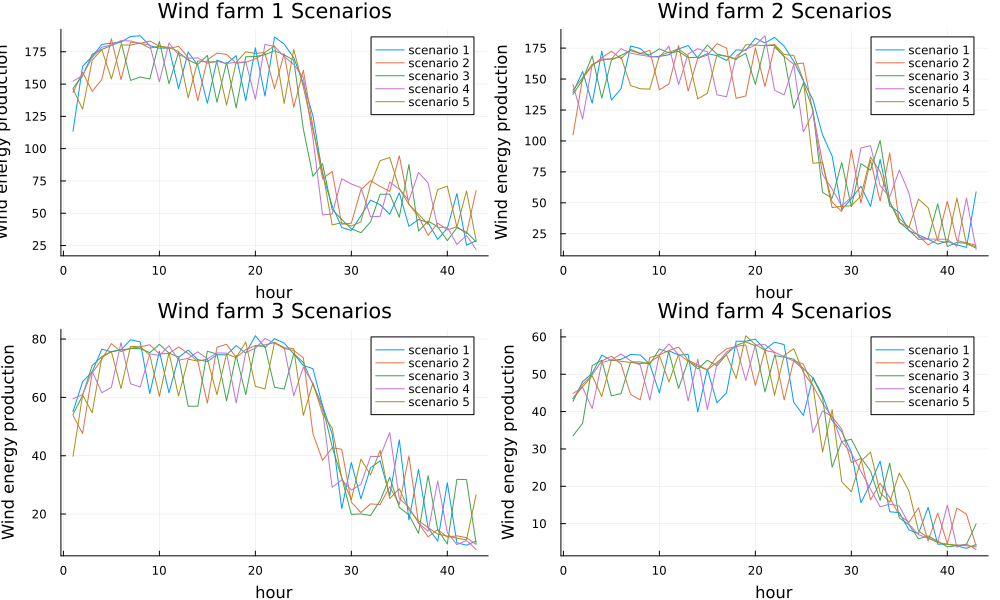

In [5]:
# look at scenario values
function get_plot(i,df)
    a = plot(collect(1:43),[df[k][i,1] for k in 1:43] ,label = "scenario 1", xlabel = "hour", ylabel = "Wind energy production", title = "Wind farm " * string(i) * " Scenarios")
    plot!(collect(1:43),[df[k][i,2] for k in 1:43] ,label = "scenario 2", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[df[k][i,3] for k in 1:43] ,label = "scenario 3", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[df[k][i,4] for k in 1:43] ,label = "scenario 4", xlabel = "hour", ylabel = "Wind energy production")
    plot!(collect(1:43),[df[k][i,5] for k in 1:43] ,label = "scenario 5", xlabel = "hour", ylabel = "Wind energy production")

    return a
end
plot(get_plot(1,scenarios),get_plot(2,scenarios),get_plot(3,scenarios),get_plot(4,scenarios),layout = (2,2),size = (1000,600))

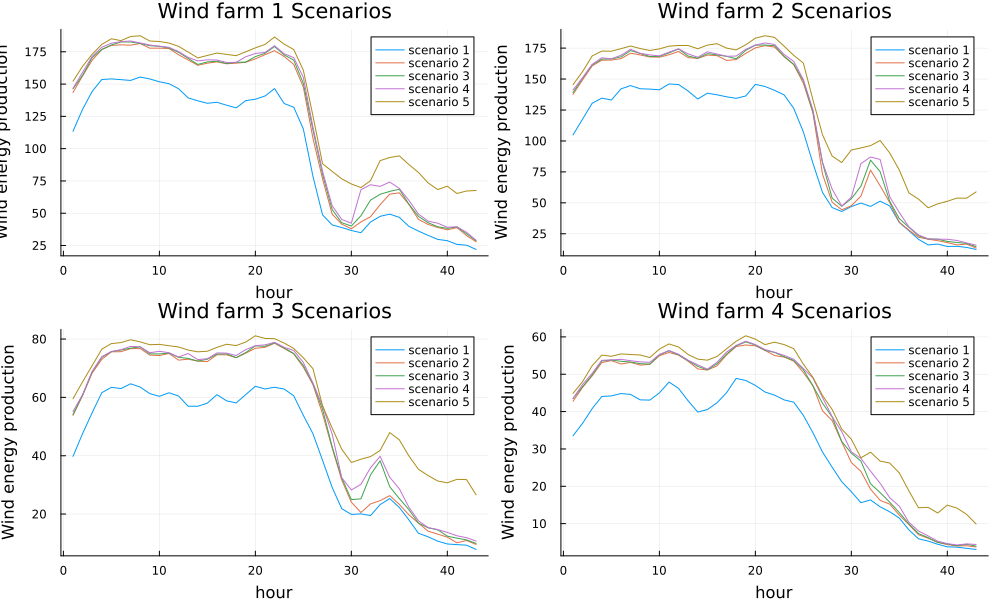

In [6]:
# Sort scenarios for better visibility (This is possible since scenarios across different hours are completly independent, meaning the scenario index across hours is meaningless)
sorted_scenarios = deepcopy(scenarios)
for k in 1:43, i in 1:4
    sorted_scenarios[k][i,:] = sort!(Array(sorted_scenarios[k][i,:]))
end
plot(get_plot(1,sorted_scenarios),get_plot(2,sorted_scenarios),get_plot(3,sorted_scenarios),get_plot(4,sorted_scenarios),layout = (2,2),size = (1000,600))

In [7]:
wind_data[1][1][1]

113.4578361798409

In [15]:
function solveModel(t::Int,data)
    m = Model(HiGHS.Optimizer)
    @variable(m, 0 <= PG[k in data[:K]] <= data[:Pmax][k]) # Power output of Generators
    @variable(m, 0 <= PW[w in data[:W]] <= data[:Wmax][w]) # schdeuled Power output of Windfarm --> max is capacity
    @variable(m, 0 <= Ru[k in data[:K]] <= data[:Rmax][k]) # Upward schelduled Reserve for each Generator
    @variable(m, 0 <= Rd[k in data[:K]] <= data[:Rmax][k]) # Downward scheduled Reserve for each Generator
    @variable(m, 0 <= Wspill[s in data[:S]] <= sum(data[:wind][t][w][s] for w in data[:W])) # Wind spillage for each scenario(no cost)
    @variable(m, 0 <= Lshed[s in data[:S]] <= sum(data[:D])) # Load shedding for each scenario
    @variable(m, 0 <= ru[k in data[:K],s in data[:S]]) #upward balancing for each scenario
    @variable(m, 0 <= rd[k in data[:K],s in data[:S]]) #downward balancing for each scenario

    @constraint(m,λ, sum(PG) + sum(PW) - sum(data[:D]) == 0) # balancing energy in day-ahead
    @constraint(m,Puu[k in data[:K], s in data[:S]], ru[k,s] <= Ru[k]) #  upward reserve dispatched cant be larger than allocated upward reserve
    @constraint(m,Pdu[k in data[:K], s in data[:S]], rd[k,s] <= Rd[k]) # downward reserve dispatched cant be larger than allocated downward reserve
    for s in data[:S]
        @constraint(m, sum(ru[k,s] - rd[k,s] for k in data[:K]) + Lshed[s] + sum(data[:wind][t][w][s] for w in data[:W]) - sum(PW) - Wspill[s] == 0) # balancing energy in real-time scenarios
    end
    @constraint(m, uRmax[k in data[:K]], PG[k] + Ru[k] <= data[:Pmax][k]) # Upward reserve + Poweroutput <= Ma  x Capacity
    @constraint(m, dRmax[k in data[:K]], PG[k] - Rd[k] >= 0) # Poweroutput - Downward reserve >= 0
    #@constraint()
    
    @expression(m,Cexp,sum(data[:prob][t][s] * ((sum(data[:C][k] * (ru[k,s] - rd[k,s]) for k in data[:K]) + data[:vLOL]*Lshed[s])) for s in data[:S]))

    @objective(m,Min, sum(data[:C][k]*PG[k] + data[:Cu][k]*Ru[k] + data[:Cd][k]*Rd[k] for k in data[:K]) + Cexp) #Balancing costs for each scenario

    
    #if(t==1)
    #    print(m)
    #end
    JuMP.optimize!(m)

    return Dict(:objective_value => objective_value(m),
    :generator_values => [value(PG[k]) for k in data[:K]],
    :wind_values => [value(PW[k]) for k in data[:W]],
    :shadow_prices => -1 * shadow_price(λ),
    :expected_cost => value(Cexp),
    :Wspills => [value(Wspill[k]) for k in data[:W]],
    :Ureserve => [value(Ru[k]) for k in data[:K]],
    :Dreserve => [value(Rd[k]) for k in data[:K]],
    :Lshed => [value(Lshed[k]) for k in data[:S]],
    :ru => [[value(ru[k,s]) for k in 1:12] for s in 1:5])
end

solveModel (generic function with 1 method)

In [20]:
data = Dict(
    :S => 1:5, # Scenarios index
    :W => 1:4, # Wind farm index
    :K => 1:12, # Generator index
    :L => 1:17, # Load index
    :C => [13.32,13.32,20.7,20.93,26.11,10.52,10.52,6.02,5.47,7.0,10.52,10.89], # Generator Energy cost
    :Cu => [1.68,1.68,3.30,4.07,1.89,5.48,5.48,4.98,5.53,8.00,3.45,5.11], # Generator upward reserve cost
    :Cd => [2.32,2.32,4.67,3.93,3.11,3.52,3.52,5.02,4.97,6.00,2.52,2.89], # Generator downward reserve cost
    :Rmax => [48,48,84,216,42,36,36,60,60,48,72,48], # Generator reserve capacity (both up and down)
    :Pmax => [106.4,106.4,245,413.7,42,108.5,108.5,280,280,210,217,245], # Generator max Capacity
    :Wmax =>[500,500,300,300], # Wind farm max capacity
    :D =>[84,75,139,58,55,106,97,132,135,150,205,150,245,77,258,141,100], # Demand energy
    :vLOL => 100.0, # value of lost load
    :wind => wind_data,
    :prob => prob_data,
    :R => 0.1 * sum([84,75,139,58,55,106,97,132,135,150,205,150,245,77,258,141,100]) # Reserve volume
)

resultsDf = DataFrame(objective = Float64[], sum_generators = Float64[],
    sum_wind = Float64[], price = Float64[],Cexp = Float64[], Lshed = Float64[])

generator_data = []
UReserve_data = []
DReserve_data =[]
Wind_data = []
expected_costs = []
Lshed = []
Wspills = []
ru = []

for i in 1:43
    results = solveModel(i,data)
    println(typeof(results))
    push!(generator_data,results[:generator_values])
    push!(UReserve_data,results[:Ureserve])
    push!(DReserve_data,results[:Dreserve])
    push!(Wind_data,results[:wind_values])
    push!(Lshed,results[:Lshed])
    push!(Wspills,results[:Wspills])
    push!(ru,results[:ru])
    push!(resultsDf,[results[:objective_value],sum(results[:generator_values]),sum(results[:wind_values]),
            results[:shadow_prices],results[:expected_cost],sum(results[:Lshed])])
end

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
150 rows, 170 cols, 454 nonzeros
149 rows, 166 cols, 445 nonzeros
Presolve : Reductions: rows 149(-1); columns 166(-4); elements 445(-9)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.5531581576e+02 Ph1: 65(120); Du: 60(155.316) 0s
        122     1.8550624416e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 122
Objective value     :  1.8550624416e+04
HiGHS run time      :          0.00
Dict{Symbol, Any}


LoadError: DimensionMismatch: Length of `row` does not match `DataFrame` column count.

## Results

In [19]:
Wind_data

43-element Vector{Any}:
 [0.0, 0.0, 102.07457394056928, 300.0]
 [0.0, 0.0, 133.2627249653287, 300.0]
 [0.0, 0.0, 165.06162176541915, 300.0]
 [0.0, 0.0, 184.9918889301071, 300.0]
 [0.0, 0.0, 190.82953499903823, 300.0]
 [0.0, 0.0, 192.4562215514842, 300.0]
 [0.0, 0.0, 198.60720395713525, 300.0]
 [0.0, 0.0, 196.27671233528952, 300.0]
 [0.0, 0.0, 188.96950862094343, 300.0]
 [0.0, 0.0, 192.2927974277551, 300.0]
 [0.0, 0.0, 194.1753433245828, 300.0]
 [0.0, 0.0, 190.90154171951986, 300.0]
 [0.0, 0.0, 183.40465841423713, 300.0]
 ⋮
 [0.0, 0.0, 0.0, 221.65231610612494]
 [0.0, 0.0, 0.0, 226.05155279693764]
 [0.0, 0.0, 0.0, 203.4922602388423]
 [0.0, 0.0, 0.0, 185.02548904583372]
 [0.0, 0.0, 0.0, 150.20440185625415]
 [0.0, 0.0, 0.0, 127.98457534283567]
 [0.0, 0.0, 0.0, 114.42923167345897]
 [0.0, 0.0, 0.0, 108.59660164158934]
 [0.0, 0.0, 0.0, 105.63830789135336]
 [0.0, 0.0, 0.0, 109.22418144068615]
 [0.0, 0.0, 0.0, 102.00194733003117]
 [0.0, 0.0, 0.0, 97.00561829239668]

In [ ]:
resultsDf

Row,objective,sum_generators,sum_wind,price,Cexp
,Float64,Float64,Float64,Float64,Float64
1,18550.6,1804.93,402.075,20.7,653.127
2,17816.5,1773.74,433.263,20.7,584.475
3,17073.4,1741.94,465.062,20.7,516.865
4,16645.2,1722.01,484.992,20.7,503.622
5,16551.6,1716.17,490.83,20.7,524.313
6,16452.9,1714.54,492.456,20.7,469.473
7,16339.4,1708.39,498.607,20.7,477.73
8,16400.4,1710.72,496.277,20.7,496.12
9,16529.4,1718.03,488.97,20.7,478.621
